In [1]:
import numpy as np
import pandas as pd
from preapre_shot_data import id_to_player_count_matrix
from flecks.models import LGCP
from flecks.util.grid_util import x_grid_centers
import matplotlib.pyplot as plt

In this project, we intent to fit the intensity surfaces for each player, utilize different matrix factorization techniques (e.g. NMF) to obtain bases for typifying the players.

We fit the intensity surface by LGCP, and the model is below:
$$\lambda_k(.) \sim LGCP(0, C)$$
$$x_k \sim PP(\lambda_k)$$
$$\lambda_k = exp(z_k + z_0)$$

the prior over $z_k$ is mean zero normal with covariance matrix 
$$C_{vu} = \sigma^2 exp(-\frac{1}{2} \sum_{d=1}^2 \frac{(x_{vd} - x_{ud})^2}{v^2_{k, d}})$$

where $v_k = \{v_{k, 1}, v_{k, 2}\}$ are gamma prior of length scale which disperse around 8ft

The code for fitting the LGCP is modified from @Andre Miller, the GitHub Repo 'flecks'.

The fitted player intensity surface is stored in the npy and presented in this Jupyter Notebook.

In [31]:
id_to_player_fit = np.load('id_to_player_fit.npy', allow_pickle=True)[()]

We could get the maximum likelihood / mean surface by the player_id. 

Take a look at the original shooting plot.

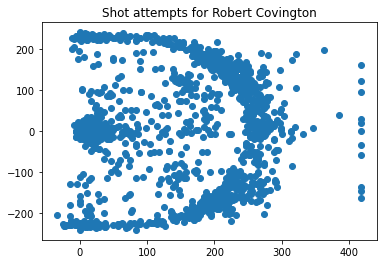

In [58]:
# 203496 is the player id for Robert Covington
from lgcp_fit import id_to_player_shot_attempts
fin = 'nba_shotchartdetail_2018-19.csv'
data = pd.read_csv(fin)
columns_to_keep = [
    'PLAYER_ID',
    'PLAYER_NAME',
    'LOC_X',
    'LOC_Y'
]
data = data[columns_to_keep]
id_to_player = id_to_player_shot_attempts(data)

fig = plt.figure()
plt.scatter(id_to_player[201939]['shot_attempts'][:,0], id_to_player[201939]['shot_attempts'][:,1])
plt.title('Shot attempts for Robert Covington')
plt.show()

Next, we can fit a surface.

In [60]:
lgcp = LGCP(dim = 2, grid_dim = (47, 50), bbox = [(-52, 418), (-250, 250)])
z_samps, h_samps, _ = lgcp.fit(id_to_player[201939]['shot_attempts'], Nsamps = 12000, burnin=2000, num_ess=10)

final acceptance rate: 0.07908333333333334


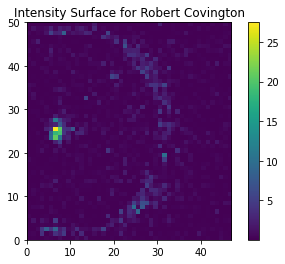

In [61]:
fig = plt.figure()
plt.imshow(lgcp.posterior_max_ll_lambda().T, interpolation='none', origin='lower', extent=[0,47,0,50])
plt.colorbar()
plt.title('Intensity Surface for Robert Covington')
plt.show()

As you can see, the accpetance rate is 0.08, which is not very well. 

Also, according to shot attempts plot, the intesity surface around the three point seems not to be fit well.

To verify our assumption, we check the parameter from the top of the court.

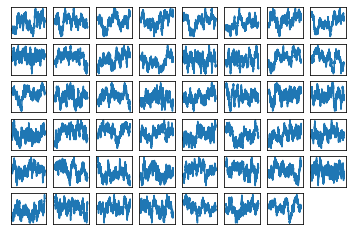

In [63]:
# 80000
fig = plt.figure()
columns = 8
rows = 6
for i in range(0, 47):
    fig.add_subplot(rows, columns, i+1)
    plt.plot(np.arange(0, 10000), lgcp._z_samps[:, 49*47 + i])
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    # plt.colorbar()
# plt.scatter(x[:,0], x[:,1])
plt.show()

From these plots, we can see that the value is not converged well. So, we might need further iterations.

However, I try some large iterations number (e.g. 80000) and it still doesn't work well. I also try to change the proposed scale, but it only makes the variance larger.

The computational cost is large as well. It takes more than 2 hours to get each player's intensity surface with 3000 iterations.

We try to utilize these fitted surface for NMF, and the result can be viewed below.

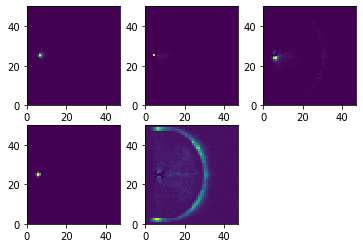

In [84]:
basis = np.load('basis.npy')
fig = plt.figure()
columns = 3
rows = 2
for i in range(1, 6):
    fig.add_subplot(rows, columns, i)
    plt.imshow(basis[i-1].T, interpolation='none', origin='lower', extent=[0,47,0,50])
plt.show()

As you can see above, the result confirms our assumption that only the values around the basket can converge easily. If we look at the expected plot, it shouldn't be like this one.

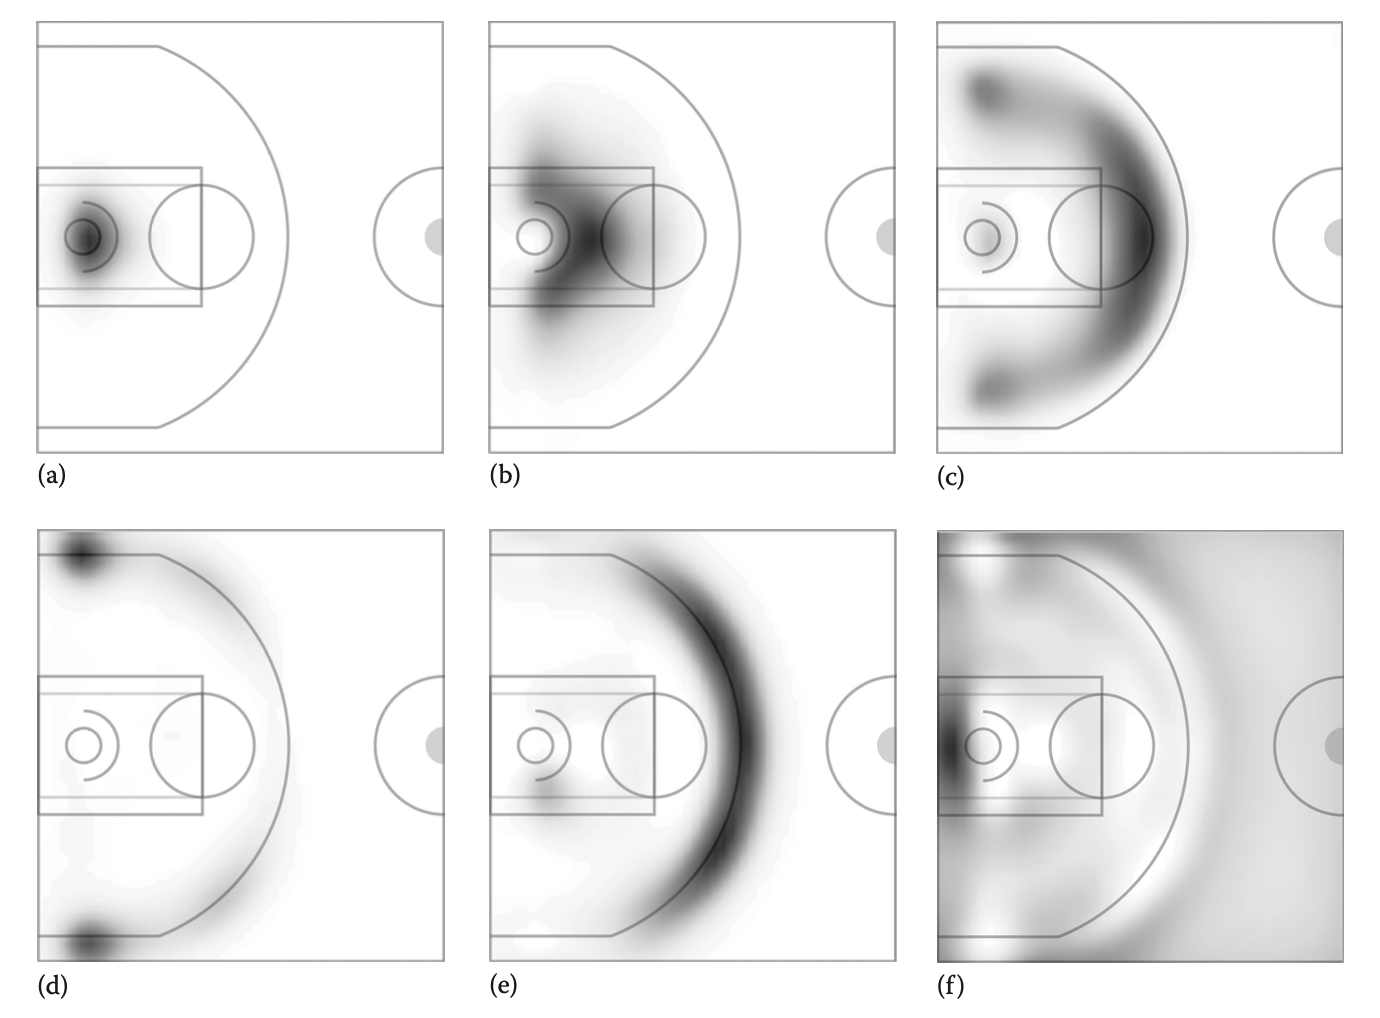

In [1]:
from IPython.display import Image
Image(filename="/Users/yhschan/Desktop/Ray's Studio/UofT/STA/STA496/expected_bases.png", height=300, width=400)

Our next step is to make sure it converges around the three point line, and we will continue the analysis for players / teams.